# Dogs vs Cats: Deep Learning with Transfer Learning & Fine-Tuning


## 1. Introduction
This notebook shows how to apply deep learning to a binary image classification problem (cats vs dogs), using both a custom CNN and transfer learning (fine-tuning VGG16). We will explore the dataset, compare the approaches, and draw insights into their successes and failures.

## 2. Data Preparation

In [7]:
import os, shutil, pathlib

# Paths - only run this block if you need to create the 5,000 image subset
original_dir = pathlib.Path("./data/kaggle_dogs_vs_cats/train")  # Full dataset dir (25,000 images)
new_base_dir = pathlib.Path("./data/kaggle_dogs_vs_cats_small")  # Desired small set

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            src = original_dir / fname
            dst = dir / fname
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)

# 1,000 train per class, 500 valid per class, 1,000 test per class
make_subset("train", 0, 1000)
make_subset("validation", 1000, 1500)
make_subset("test", 1500, 2500)


## 3. Exploratory Data Analysis (EDA)

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import collections
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory

data_folder = pathlib.Path('./data/kaggle_dogs_vs_cats_small')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32,
    shuffle=True
)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32
)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### 3.1 Dataset Overview

In [9]:
class_names = train_dataset.class_names
print("Class names:", class_names)
print("Training batches:", train_dataset.cardinality().numpy())
print("Validation batches:", validation_dataset.cardinality().numpy())
print("Test batches:", test_dataset.cardinality().numpy())


Class names: ['cat', 'dog']
Training batches: 63
Validation batches: 32
Test batches: 63


### 3.2 Visualizing Images

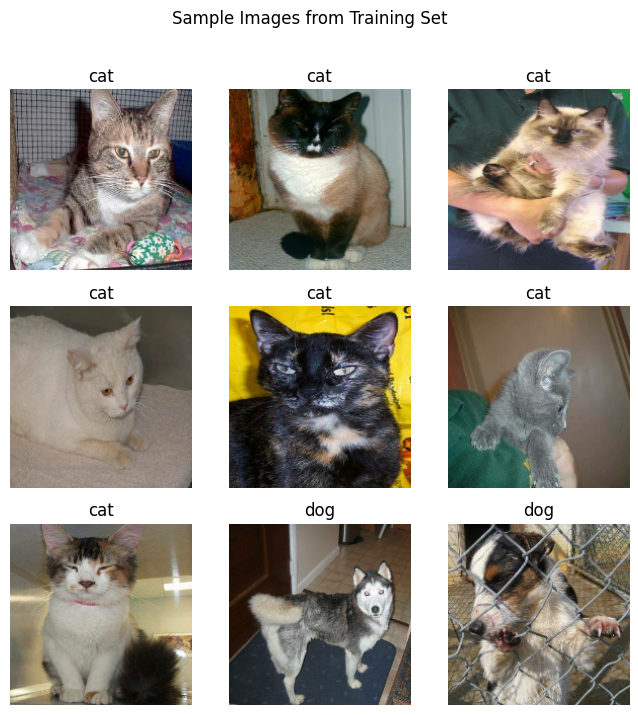

In [10]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Set")
plt.show()


### 3.3 Class Balance

In [11]:
counter = collections.Counter()
for _, labels in train_dataset:
    counter.update(labels.numpy())
print({class_names[i]: count for i, count in counter.items()})


{'dog': 1000, 'cat': 1000}


## 4. Model 1 – Custom Convolutional Neural Network (CNN)


### 4.1 Model Design


In [12]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(128, 3, activation="relu")(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
cnn_model = keras.Model(inputs, outputs)
cnn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,276,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,177 (12.86 MB)

 Trainable params: 3,370,177 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 Training


In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="cnn_best_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_cnn = cnn_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 720ms/step - accuracy: 0.5270 - loss: 0.7335 - val_accuracy: 0.5000 - val_loss: 0.6908
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 687ms/step - accuracy: 0.5765 - loss: 0.6675 - val_accuracy: 0.6350 - val_loss: 0.6341
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 681ms/step - accuracy: 0.6735 - loss: 0.6028 - val_accuracy: 0.6640 - val_loss: 0.6142
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 690ms/step - accuracy: 0.7380 - loss: 0.5203 - val_accuracy: 0.6780 - val_loss: 0.6245
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 700ms/step - accuracy: 0.7820 - loss: 0.4482 - val_accuracy: 0.6850 - val_loss: 0.6028
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 680ms/step - accuracy: 0.8395 - loss: 0.3652 - val_accuracy: 0.7060 - val_loss: 0.6458
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 687ms/step - accuracy: 0.8840 - loss: 0.2675 - val_accuracy: 0.6850 - val_loss: 0.7853
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 690ms/step - accuracy: 0.9215 - loss: 0.1993 - val_accu

### 4.3 Learning Curves


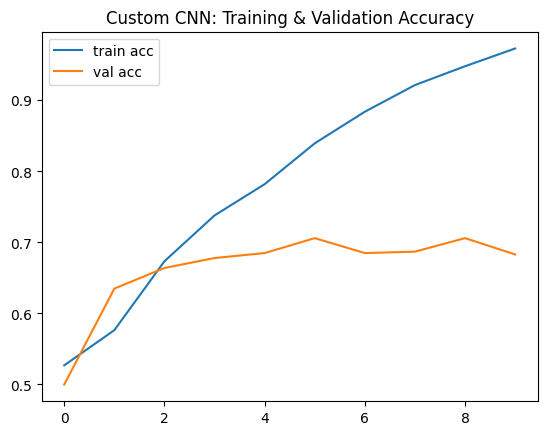

In [14]:
plt.plot(history_cnn.history["accuracy"], label="train acc")
plt.plot(history_cnn.history["val_accuracy"], label="val acc")
plt.title("Custom CNN: Training & Validation Accuracy")
plt.legend()
plt.show()


## 5. Model 2 – Transfer Learning (VGG16 Fine-Tuning)


### 5.1  Using VGG16 as the Base


In [15]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(180, 180, 3))
conv_base.trainable = False  # Freeze for initial training


### 5.2 Model Construction


In [16]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
vgg_model = keras.Model(inputs, outputs)
vgg_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
vgg_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,992,001 (68.63 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 5.3 Training


In [17]:
callbacks_ft = [
    keras.callbacks.ModelCheckpoint(
        filepath="vgg16_finetune_best.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_vgg = vgg_model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks_ft
)


Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 456s 7s/step - accuracy: 0.9010 - loss: 3.3320 - val_accuracy: 0.9760 - val_loss: 0.6413
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 434s 7s/step - accuracy: 0.9360 - loss: 1.1559 - val_accuracy: 0.9780 - val_loss: 0.2652
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 440s 7s/step - accuracy: 0.9610 - loss: 0.5103 - val_accuracy: 0.9820 - val_loss: 0.1476
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 436s 7s/step - accuracy: 0.9575 - loss: 0.2263 - val_accuracy: 0.9830 - val_loss: 0.1072
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 437s 7s/step - accuracy: 0.9665 - loss: 0.1591 - val_accuracy: 0.9800 - val_loss: 0.1135
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 439s 7s/step - accuracy: 0.9685 - loss: 0.1327 - val_accuracy: 0.9790 - val_loss: 0.0973
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 441s 7s/step - accuracy: 0.9700 - loss: 0.1182 - val_accuracy: 0.9800 - val_loss: 0.0700
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 434s 7s/step - accuracy: 0.9730 - loss: 0.0924 - val_accuracy: 0.9830 - v

5.4 Fine-Tuning Higher Layers


In [18]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

vgg_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(1e-5), metrics=["accuracy"])

# Continue training for a few epochs to fine-tune
history_fine = vgg_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks_ft
)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 535s 8s/step - accuracy: 0.9730 - loss: 0.1068 - val_accuracy: 0.9850 - val_loss: 0.0558
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 532s 8s/step - accuracy: 0.9890 - loss: 0.0361 - val_accuracy: 0.9860 - val_loss: 0.0611
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 487s 8s/step - accuracy: 0.9840 - loss: 0.0564 - val_accuracy: 0.9620 - val_loss: 0.1741
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 500s 8s/step - accuracy: 0.9840 - loss: 0.0502 - val_accuracy: 0.9840 - val_loss: 0.0642
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 491s 8s/step - accuracy: 0.9855 - loss: 0.0429 - val_accuracy: 0.9830 - val_loss: 0.0612
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 469s 8s/step - accuracy: 0.9885 - loss: 0.0234 - val_accuracy: 0.9840 - val_loss: 0.0689


## 6. Model Evaluation & Comparison


### 6.1 Reloading Best Models


In [19]:
best_cnn = keras.models.load_model("cnn_best_model.keras")
best_vgg = keras.models.load_model("vgg16_finetune_best.keras")


### 6.2 Accuracy Scores


In [20]:
cnn_loss, cnn_acc = best_cnn.evaluate(test_dataset)
vgg_loss, vgg_acc = best_vgg.evaluate(test_dataset)
print(f"Custom CNN Test Accuracy: {cnn_acc:.3f}")
print(f"VGG16 Fine-Tuned Test Accuracy: {vgg_acc:.3f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.7225 - loss: 0.6001
63/63 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9765 - loss: 0.0936
Custom CNN Test Accuracy: 0.723
VGG16 Fine-Tuned Test Accuracy: 0.976


### 6.3 Confusion Matrix and Metrics


In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

# Collect predictions and true labels
y_true = []
y_cnn_pred = []
y_vgg_pred = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    y_cnn_pred.extend(best_cnn.predict(images).flatten())
    y_vgg_pred.extend(best_vgg.predict(images).flatten())
y_true = np.array(y_true)
y_cnn_bin = np.array(y_cnn_pred) > 0.5
y_vgg_bin = np.array(y_vgg_pred) > 0.5

cm_cnn = confusion_matrix(y_true, y_cnn_bin)
cm_vgg = confusion_matrix(y_true, y_vgg_bin)
print("CNN Confusion Matrix:\n", cm_cnn)
print("VGG Confusion Matrix:\n", cm_vgg)

print(f'Custom CNN - Precision: {precision_score(y_true, y_cnn_bin):.2f}, Recall: {recall_score(y_true, y_cnn_bin):.2f}, F1: {f1_score(y_true, y_cnn_bin):.2f}')
print(f'VGG16 Fine-Tuned - Precision: {precision_score(y_true, y_vgg_bin):.2f}, Recall: {recall_score(y_true, y_vgg_bin):.2f}, F1: {f1_score(y_true, y_vgg_bin):.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### 6.4 Precision-Recall Curve


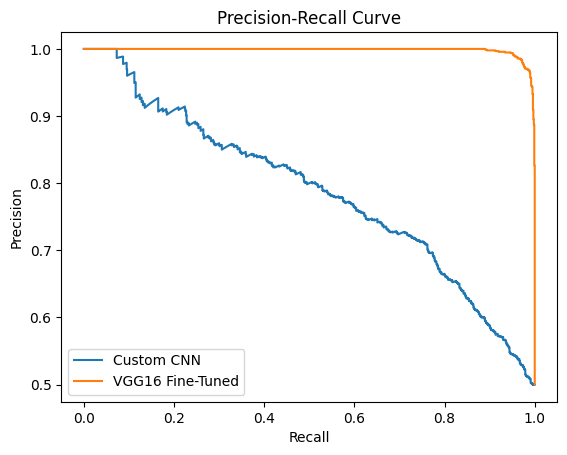

In [22]:
pr_cnn = precision_recall_curve(y_true, y_cnn_pred)
pr_vgg = precision_recall_curve(y_true, y_vgg_pred)

plt.plot(pr_cnn[1], pr_cnn[0], label='Custom CNN')
plt.plot(pr_vgg[1], pr_vgg[0], label='VGG16 Fine-Tuned')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


### 6.5 Failure Analysis


Number of incorrect predictions: 582


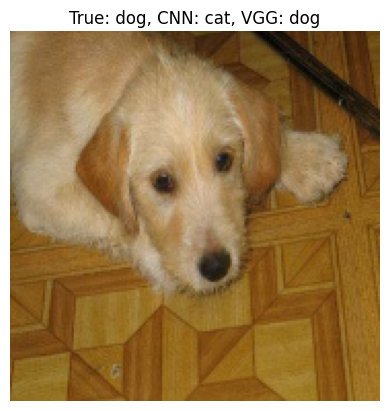

In [23]:
import random
failure_idxs = np.where((y_true != y_cnn_bin) | (y_true != y_vgg_bin))[0]
print(f"Number of incorrect predictions: {len(failure_idxs)}")
if len(failure_idxs) > 0:
    ix = random.choice(failure_idxs)
    for batch_images, batch_labels in test_dataset:
        if ix < len(batch_labels):
            img = batch_images[ix].numpy().astype("uint8")
            plt.imshow(img)
            plt.title(
                f"True: {class_names[batch_labels[ix]]}, CNN: {class_names[int(y_cnn_bin[ix])]}, VGG: {class_names[int(y_vgg_bin[ix])]}")
            plt.axis("off")
            plt.show()
            break
        ix -= len(batch_labels)


## 7. Discussion and Conclusions
### Summary Points:

Which model performed better? Why?

How did transfer learning accelerate or improve learning?

Any clear signs of overfitting or underfitting? How did callbacks or augmentation help?

What types of images did both models struggle with?

What would be the next steps to further boost performance?

Takeaways:

Transfer learning typically delivers strong gains even with relatively small data.

Model choice depends on dataset size, resources, and the need for maximum accuracy.